In [ ]:
import csv
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, Concatenate, Dot, Lambda

In [ ]:
from tqdm.notebook import tqdm
import csv

# Read data from text
with open('train_snli.txt') as file:
    data = file.readlines()

# Prepare csv file
with open('data.csv', 'w', newline='') as csvfile:
    filenames = ['source_txt', 'plagiarism_txt', 'label']
    writer = csv.DictWriter(csvfile, fieldnames=filenames)

    writer.writeheader()
    for line in tqdm(data):
        parts = line.strip().split('\t')
        if len(parts) < 3:
            print(f"Skipping line due to insufficient data: {line}")
            continue
        source_txt = parts[0]
        plagiarism_txt = parts[1]
        label = int(parts[2])

        writer.writerow({
            'source_txt': source_txt,
            'plagiarism_txt': plagiarism_txt,
            'label': label
        })
print('CSV file created successfully...')


  0%|          | 0/367373 [00:00<?, ?it/s]

CSV file created successfully...


In [ ]:
df = pd.read_csv('data.csv')

In [ ]:
df.head()

,source_txt,plagiarism_txt,label
0,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",0
1,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",1
2,Children smiling and waving at camera,There are children present,1
3,Children smiling and waving at camera,The kids are frowning,0
4,A boy is jumping on skateboard in the middle o...,The boy skates down the sidewalk.,0


In [ ]:
df.isnull().sum()

source_txt        0
plagiarism_txt    4
label             0
dtype: int64

In [ ]:
df.duplicated().sum()

276

In [ ]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

<Axes: xlabel='label'>

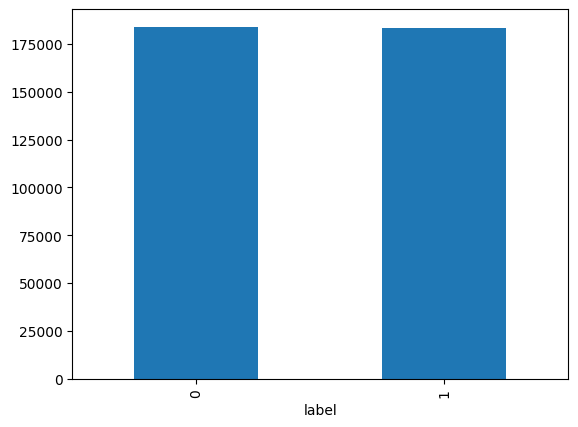

In [ ]:
df['label'].value_counts().plot(kind='bar')

In [ ]:
import string

def preprocess_text(text):
    if isinstance(text, str):
        # Remove punctuation
        text = text.translate(str.maketrans("", "", string.punctuation))
        # Convert to lowercase
        text = text.lower()
    return text

In [ ]:
df['source_txt'] = df['source_txt'].apply(preprocess_text)
df['plagiarism_txt'] = df['plagiarism_txt'].apply(preprocess_text)

In [ ]:
df.head()

,source_txt,plagiarism_txt,label
0,a person on a horse jumps over a broken down a...,a person is at a diner ordering an omelette,0
1,a person on a horse jumps over a broken down a...,a person is outdoors on a horse,1
2,children smiling and waving at camera,there are children present,1
3,children smiling and waving at camera,the kids are frowning,0
4,a boy is jumping on skateboard in the middle o...,the boy skates down the sidewalk,0


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['source_txt'] + '' + df['plagiarism_txt'])
X = tokenizer.texts_to_sequences(df['source_txt'] + '' + df['plagiarism_txt'])
X = pad_sequences(X)
y = df['label']
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
model = Sequential([
    Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_length = X.shape[1]),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 111, 100)          7534900   
                                                                 
 lstm (LSTM)                 (None, 111, 128)          117248    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 7701621 (29.38 MB)
Trainable params: 7701621 (29.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Step 6: Train the model
model.fit(x_train, y_train, batch_size=64, epochs=1, validation_data=[x_test, y_test])

4587/4587 [==============================] - 3416s 743ms/step - loss: 0.4882 - accuracy: 0.7503 - val_loss: 0.4347 - val_accuracy: 0.7900


In [ ]:
import pickle
model.save('model.h5')
with open('tokenizer.pkl','wb') as file:
    pickle.dump(tokenizer, file)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import pickle
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load your model
model = load_model('model.h5')
file = open('tokenizer.pkl', 'rb')
tokenizer = pickle.load(file)
file.close()

# Quantize the model
quantized_model = tf.keras.models.clone_model(model)
quantized_model.set_weights(model.get_weights())
quantized_model.compile(optimizer=model.optimizer, loss=model.loss)

# Save the quantized model
quantized_model.save('quantized_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
def pre_text(text):
    sequences = tokenizer.texts_to_sequences([text])
    padded_sequences = pad_sequences(sequences, maxlen = 111)
    return padded_sequences
def predict_plagiarism(text):
    process_text = pre_text(text)
    predictions = model.predict(process_text)
    return predictions[0][0]


In [ ]:
%pip install torch transformers

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import pandas as pd
import nltk
from nltk.corpus import gutenberg
import re

# Ensure NLTK resources are downloaded
nltk.download('gutenberg')
nltk.download('punkt')

# Set up GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load GPT-2 model and tokenizer
model_name = 'gpt2'
model = GPT2LMHeadModel.from_pretrained(model_name).to(device)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Add padding token
tokenizer.pad_token = tokenizer.eos_token

# Function to preprocess text
def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'\n', ' ', text)  # Remove newlines
    text = re.sub(r'[^a-zA-Z0-9 .,;?!]', '', text)  # Remove special characters except punctuation
    return text.strip()

# Function to generate text in batches
def generate_texts(prompts, max_length=512, batch_size=10):
    texts = []
    for i in range(0, len(prompts), batch_size):
        batch_prompts = prompts[i:i + batch_size]
        inputs = tokenizer(batch_prompts, return_tensors="pt", padding=True, truncation=True).to(device)
        outputs = model.generate(inputs.input_ids, max_length=max_length, num_return_sequences=1)
        texts.extend(tokenizer.batch_decode(outputs, skip_special_tokens=True))
    return texts

# Step 1: Collect Human-made Writings
gutenberg_texts = gutenberg.fileids()
human_texts = []
prompts = []
num_sentences = 5  # Number of sentences to match the AI-generated content

for file_id in gutenberg_texts:
    text = gutenberg.raw(file_id)
    sentences = nltk.sent_tokenize(text)

    if len(sentences) >= num_sentences:
        prompt_words = sentences[0].split()[:50]  # Take the first 50 words as the prompt
        prompt = ' '.join(prompt_words)

        # Check if the first words contain a title marker and adjust
        if prompt.startswith("[") and "]" in prompt:
            prompt = ' '.join(prompt.split("]")[1].split()[:50])
            #[Judul] isi

        prompts.append(prompt)
        human_text = ' '.join(sentences[:num_sentences])  # Use the first num_sentences sentences as the human text
        human_text = preprocess_text(human_text)  # Preprocess the text
        human_texts.append(human_text)

# Ensure we have around 350 human texts and corresponding prompts
human_texts = human_texts[:350]
prompts = prompts[:350]

# If prompts list is less than 350, repeat prompts to ensure it has 350 entries
if len(prompts) < 350:
    prompts = prompts * (350 // len(prompts)) + prompts[:350 % len(prompts)]

# Step 2: Generate AI-made Essays
ai_texts = generate_texts(prompts, max_length=500, batch_size=10)
ai_texts = [preprocess_text(text) for text in ai_texts]  # Preprocess the AI texts
human_texts = [preprocess_text(text) for text in human_texts]

# Step 3: Prepare the Human Dataset
human_df = pd.DataFrame({'text': human_texts})

# Step 4: Prepare the AI Dataset
ai_df = pd.DataFrame({'text': ai_texts})

# Step 5: Export the Datasets to CSV
human_df.to_csv('human_texts.csv', index=False)
ai_df.to_csv('ai_texts.csv', index=False)

print("Datasets successfully created and saved as 'human_texts.csv' and 'ai_texts.csv'")


[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Using device: cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` t

Datasets successfully created and saved as 'human_texts.csv' and 'ai_texts.csv'


In [ ]:
df1 = pd.read_csv("human_texts.csv")
df2 = pd.read_csv("ai_texts.csv")

In [ ]:
df1['Label'] = "human"

In [ ]:
df1.head()

,text,Label
0,"Flax. From house to house he goes, A messenger...",human
1,"Flax. From house to house he goes, A messenger...",human
2,The Absence of Mr Glass THE consultingrooms of...,human
3,Supplied by a Late Consumptive Usher to a Gram...,human
4,She was the youngest of the two daughters of a...,human


In [ ]:
df2['Label'] = "ai"

In [ ]:
human_ai = pd.concat([df1, df2])

In [ ]:
%pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 4.7 MB/s eta 0:00:00


In [ ]:
data = pd.read_csv('human_ai.csv', delimiter = ',')

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from collections import Counter

# Load the SBERT model
model2 = SentenceTransformer('distiluse-base-multilingual-cased-v1')

# Generate embeddings for the text data
embeddings = model2.encode(data['text'].tolist())

# Prepare features and labels
X = embeddings
y = data['Label']
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
# Adjusting test_size to ensure sufficient samples in each class
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.5, random_state=42, stratify=y)

# Check the class distribution
print(f"Class distribution: {Counter(y_train)}")

# Train a Multinomial Naive Bayes classifier
classifierNB = MultinomialNB()
classifierNB.fit(X_train, y_train)

# Predict and evaluate
y_pred = classifierNB.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Detailed evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))




/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.47k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/556 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/452 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

Class distribution: Counter({'ai': 175, 'human': 175})
Accuracy: 0.92
Confusion Matrix:
[[147  28]
 [  0 175]]
Classification Report:
              precision    recall  f1-score   support

          ai       1.00      0.84      0.91       175
       human       0.86      1.00      0.93       175

    accuracy                           0.92       350
   macro avg       0.93      0.92      0.92       350
weighted avg       0.93      0.92      0.92       350



In [ ]:
def predict_plagiarism_nb(text):
    # Generate embedding for the text
    embedding = model2.encode([text])
    embedding_scaled = scaler.transform(embedding)
    prediction_proba = classifierNB.predict_proba(embedding_scaled)
    return prediction_proba[0][1]

In [ ]:
new_text = "At dawn, the serene lake mirrored the vibrant sunrise, as birds chirped melodiously, welcoming the start of a new day."
ltsm = predict_plagiarism(new_text)
nbprediction = predict_plagiarism_nb(new_text)
print(f"The probability of this text being plagiarised is : {ltsm*100}%")
print(f"The probability of this text being AI - : {nbprediction*100}%")

1/1 [==============================] - 0s 165ms/step
The probability of this text being plagiarised is : 45.96808850765228%
The probability of this text being AI - : 99.81098243623079%
